In [1]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report
import mlflow.tensorflow
import mlflow
from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """

    image_array = np.zeros(shape=(len(data), 48, 48, 1))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48, 1))  # 灰階圖的channel數為1
        image_array[i] = image

    return image_array, image_label


def plot_one_emotion(data, img_arrays, img_labels, label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace=.2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion'] == label].index[i]
        axs[i].imshow(img_arrays[idx][:, :, 0], cmap='gray')
        axs[i].set_title(emotions[img_labels[idx]])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])


def plot_conv_feature(data, img_arrays, img_labels, label=0):
    fig, axs = plt.subplots(4, 4, figsize=(16, 16))
    fig.subplots_adjust(hspace=.2, wspace=.2)
    axs = axs.flatten()
    for i in range(16):
        idx = data[data['cluster'] == label].index[i]
        axs[i].imshow(img_arrays[idx], cmap='gray')
        axs[i].set_title(f"feature {i}, cluster {label}", size=20)
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])


def convert_to_3_channels(img_arrays):
    sample_size, nrows, ncols, c = img_arrays.shape
    img_stack_arrays = np.zeros((sample_size, nrows, ncols, 3))
    for _ in range(sample_size):
        img_stack = np.stack(
            [img_arrays[_][:, :, 0], img_arrays[_][:, :, 0], img_arrays[_][:, :, 0]], axis=-1)
        img_stack_arrays[_] = img_stack/255
    return img_stack_arrays


def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """

    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

    bar_label = emotions.values()

    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])

    axs[1].bar(bar_label, pred_test_labels[image_number],
               color='orange', alpha=0.7)
    axs[1].grid()

    plt.show()


emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear',
            3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [3]:
df_raw = pd.read_csv("D:/mycodes/AIFER/data/fer2013.csv")
# 樣本分布(訓練、公開測試、私人測試集)
df_raw['Usage'].value_counts()  # 8:1:1
# 資料切割(訓練、驗證、測試)
df_train = df_raw[df_raw['Usage'] == 'Training']
df_val = df_raw[df_raw['Usage'] == 'PublicTest']
df_test = df_raw[df_raw['Usage'] == 'PrivateTest']

X_train, y_train = prepare_data(df_train)
X_val, y_val = prepare_data(df_val)
X_test, y_test = prepare_data(df_test)

X_train = convert_to_3_channels(X_train)
X_val = convert_to_3_channels(X_val)
X_test = convert_to_3_channels(X_test)

y_train_oh = to_categorical(y_train)
y_val_oh = to_categorical(y_val)
y_test_oh = to_categorical(y_test)

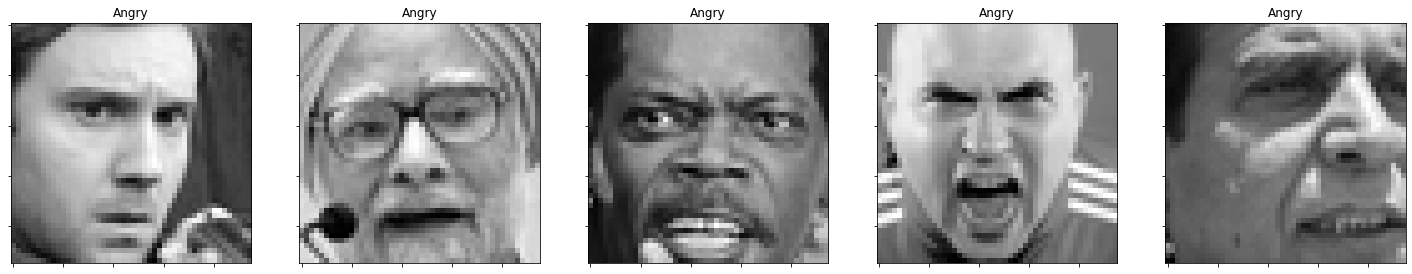

In [4]:
plot_one_emotion(df_train, X_train, y_train, label=0)

In [5]:
def build_model(num_classes=7):
    pred_model = vgg16.VGG16(include_top=False, weights='imagenet',
                             input_shape=(48, 48, 3),
                             pooling='max', classifier_activation='softmax')

    output_layer = Dense(
        num_classes, activation="softmax", name="output_layer")

    model = tf.keras.Model(
        pred_model.inputs, output_layer(pred_model.output))

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

    return model


model_vgg16 = build_model()
prob_vgg16 = model_vgg16(X_train[:1]).numpy()
print(prob_vgg16.shape)

(1, 7)


In [6]:
epochs = 30
batch_size = 32
with mlflow.start_run(experiment_id=0, run_name="vgg16"):
    mlflow.tensorflow.autolog()
    hist1 = model_vgg16.fit(X_train, y_train_oh, validation_data=(X_val, y_val_oh),
                            epochs=epochs, batch_size=batch_size)
mlflow.end_run()

Epoch 1/30
  1/898 [..............................] - ETA: 0s - loss: 2.4876 - accuracy: 0.0312WARNING:tensorflow:From C:\Users\USER\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
898/898 [==============================] - 119s 132ms/step - loss: 1.8299 - accuracy: 0.2450 - val_loss: 1.7507 - val_accuracy: 0.2675
Epoch 2/30
898/898 [==============================] - 111s 123ms/step - loss: 1.6324 - accuracy: 0.3386 - val_loss: 1.4617 - val_accuracy: 0.4383
Epoch 3/30
898/898 [==============================] - 108s 120ms/step - loss: 1.3831 - accuracy: 0.4559 - val_loss: 1.3217 - val_accuracy: 0.4976
Epoch 4/30
898/898 [==============================] - 105s 117ms/step - loss: 1.2513 - accuracy: 0.5222 - val_loss: 1.2384 - val_accuracy: 0.5300
Epoch 5/30
898/898 [==

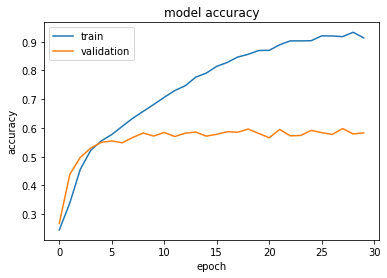

In [7]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist1)

113/113 [==============================] - 4s 34ms/step - loss: 1.9863 - accuracy: 0.5826
val acc:0.5826135277748108	 val loss:1.986326813697815


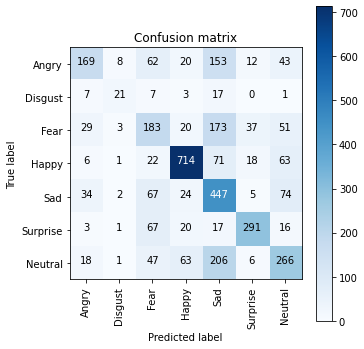

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


loss, acc = model_vgg16.evaluate(
    x=X_val, y=y_val_oh, batch_size=32, workers=1, use_multiprocessing=False)

y_prob = model_vgg16.predict(X_val)
y_pred = np.argmax(y_prob, axis=1)
CM = confusion_matrix(y_val, y_pred)
print(f"val acc:{acc}\t val loss:{loss}")
plot_confusion_matrix(CM, classes=list(emotions.values()))

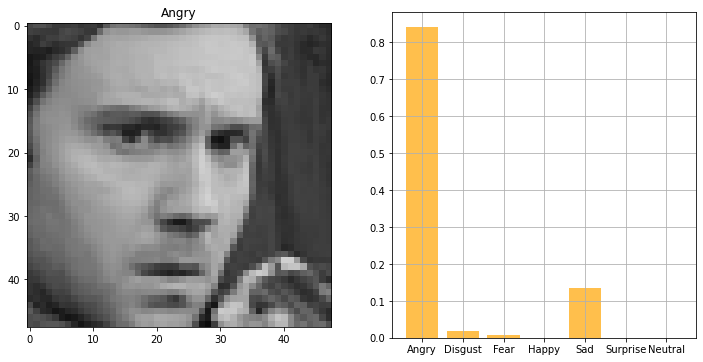

In [9]:
y_prob_train = model_vgg16.predict(X_train)
plot_image_and_emotion(X_train, y_train, y_prob_train, 0)